# Setup

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '../../data/SLA/'
# infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018_processed.nc'
infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2020_03_01_dtrnd_bin.nc'

ds_SLA = xr.open_dataset(path + infn)
ds_SLA

<xarray.Dataset>
Dimensions:                        (latitude: 200, latitude_1deg: 50, longitude: 340, longitude_1deg: 85, month: 12, month_time: 315, season: 4, season_time: 106, time: 9563)
Coordinates:
  * season_time                    (season_time) datetime64[ns] 1993-12-01 ... 2020-03-01
  * longitude                      (longitude) float64 35.12 35.38 ... 119.9
  * latitude                       (latitude) float64 -19.88 -19.62 ... 29.88
  * time                           (time) datetime64[ns] 1994-01-01 ... 2020-03-07
  * month_time                     (month_time) datetime64[ns] 1994-01-01 ... 2020-03-01
  * month                          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season                         (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * latitude_1deg                  (latitude_1deg) float64 -20.0 -19.0 ... 29.0
  * longitude_1deg                 (longitude_1deg) float64 35.0 36.0 ... 119.0
Data variables:
    daily_sla_dtrnd                (time, latitude,

In [2]:
# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 105) # bounds inclusive

# Get data, selecting lat/lon slice
# mon_sla_dtrnd = ds_SLA['mon_sla_dtrnd_1deg'].sel(latitude_1deg=lat_slice,longitude_1deg=lon_slice)
mon_sla_mon_anom_dtrnd = ds_SLA['mon_sla_mon_anom_dtrnd_1deg'].sel(latitude_1deg=lat_slice,longitude_1deg=lon_slice)
sla_mon_clim_dtrnd = ds_SLA['sla_mon_clim_dtrnd_1deg'].sel(latitude_1deg=lat_slice,longitude_1deg=lon_slice)
lat = mon_sla_mon_anom_dtrnd.latitude_1deg.values
lon = mon_sla_mon_anom_dtrnd.longitude_1deg.values

In [3]:
# ds_CD = xr.open_dataset('../data/CD/CD.nc')
# ds_CD

In [4]:
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

# Find Coastlines

Text(0.5, 1.0, 'Unordered Stations')

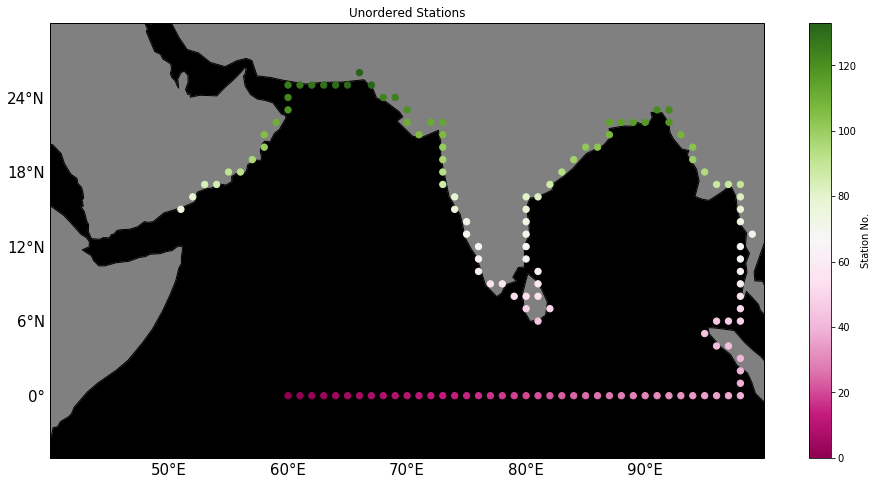

In [5]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_mon_anom_dtrnd[0,:,:]
xx,yy = np.meshgrid(lon,lat)
# set Gulfs to Nans
mask = np.where(~((yy>22) & (xx<60)),mask,np.nan)
mask = np.where(~((yy>10) & (xx<51)),mask,np.nan)

# AS inlets
mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)
mask = np.where(~((yy>22.25) & (yy<22) & (xx>69) & (xx<70.5)),mask,np.nan)
mask = np.where(~((yy>23.25) & (yy<22) & (xx>69) & (xx<70)),mask,np.nan)

# sri lanka are
mask = np.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80.5)),mask,np.nan)

# Sumatra area
mask = np.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<99)),mask,np.nan)
mask = np.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<101)),mask,np.nan)
mask = np.where(~((yy>-1) & (yy<12) & (xx>98) & (xx<102)),mask,np.nan)
mask = np.where(~((yy>11.5) & (yy<13) & (xx>98)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[17:]
sta_loninds_unord = sta_loninds_unord[17:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-5,30]

cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(11, 35) [(58, 26), (58, 20)]


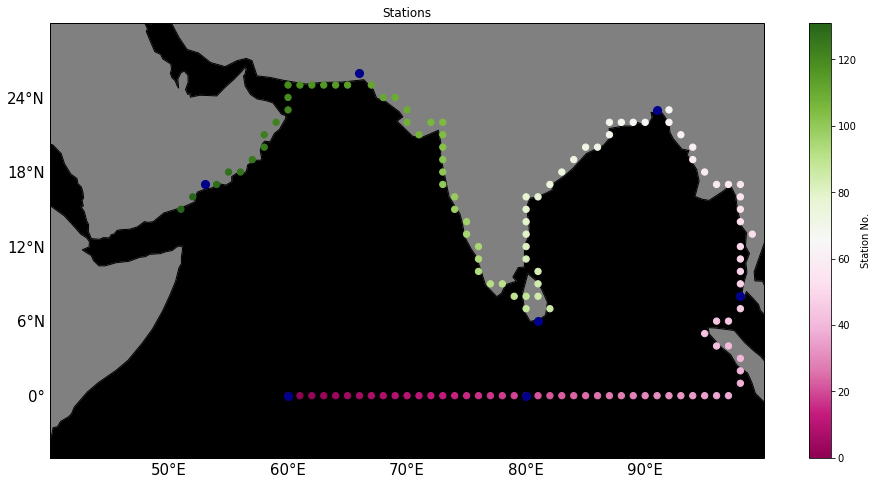

In [6]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 20
sBoB = 47
mBoB = 65
SL = 87
mAS = 113
eAS = 129
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Stations')

plt.savefig('../../figures/stations-SLA-along-coast-1-deg.png', dpi=300, bbox_inches='tight')

In [7]:
# no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))
# # convert to xarray dataset
# ds=xr.Dataset(coords={'no_stations': no_stations})

# ds['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
# ds['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
# ds['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])
# ds.to_netcdf('../../data/SLA/SLA-1-degree-coastlines.nc',mode='w',format = "NETCDF4")
# ds

<xarray.Dataset>
Dimensions:      (loc_list: 7, no_stations: 132)
Coordinates:
  * no_stations  (no_stations) float64 1.0 2.0 3.0 4.0 ... 130.0 131.0 132.0
  * loc_list     (loc_list) int64 0 20 47 65 87 113 129
Data variables:
    sta_loninds  (no_stations) int64 20 21 22 23 24 25 26 ... 16 15 14 13 12 11
    sta_latinds  (no_stations) int64 20 20 20 20 20 20 20 ... 38 38 37 37 36 35

# Group Anomalies Into IOD Phases

In [37]:
# load DMI data
ds_DMI= xr.open_dataset('../../data/DMI/dmi_processed.nc')
ds_DMI

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994])) 
negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994])) 
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994])) 

In [38]:
# average over the positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
posIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
posIOD_mon_sla_mon_anom_dtrnd = posIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
posIOD_mon_sla_mon_anom_dtrnd =posIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neg_IOD_years))):
for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))
    
negIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
negIOD_mon_sla_mon_anom_dtrnd = negIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
negIOD_mon_sla_mon_anom_dtrnd =negIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the neutral IOD years -------------------------------------------# 
daily_data = []
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neu_IOD_years))):
for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

neuIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


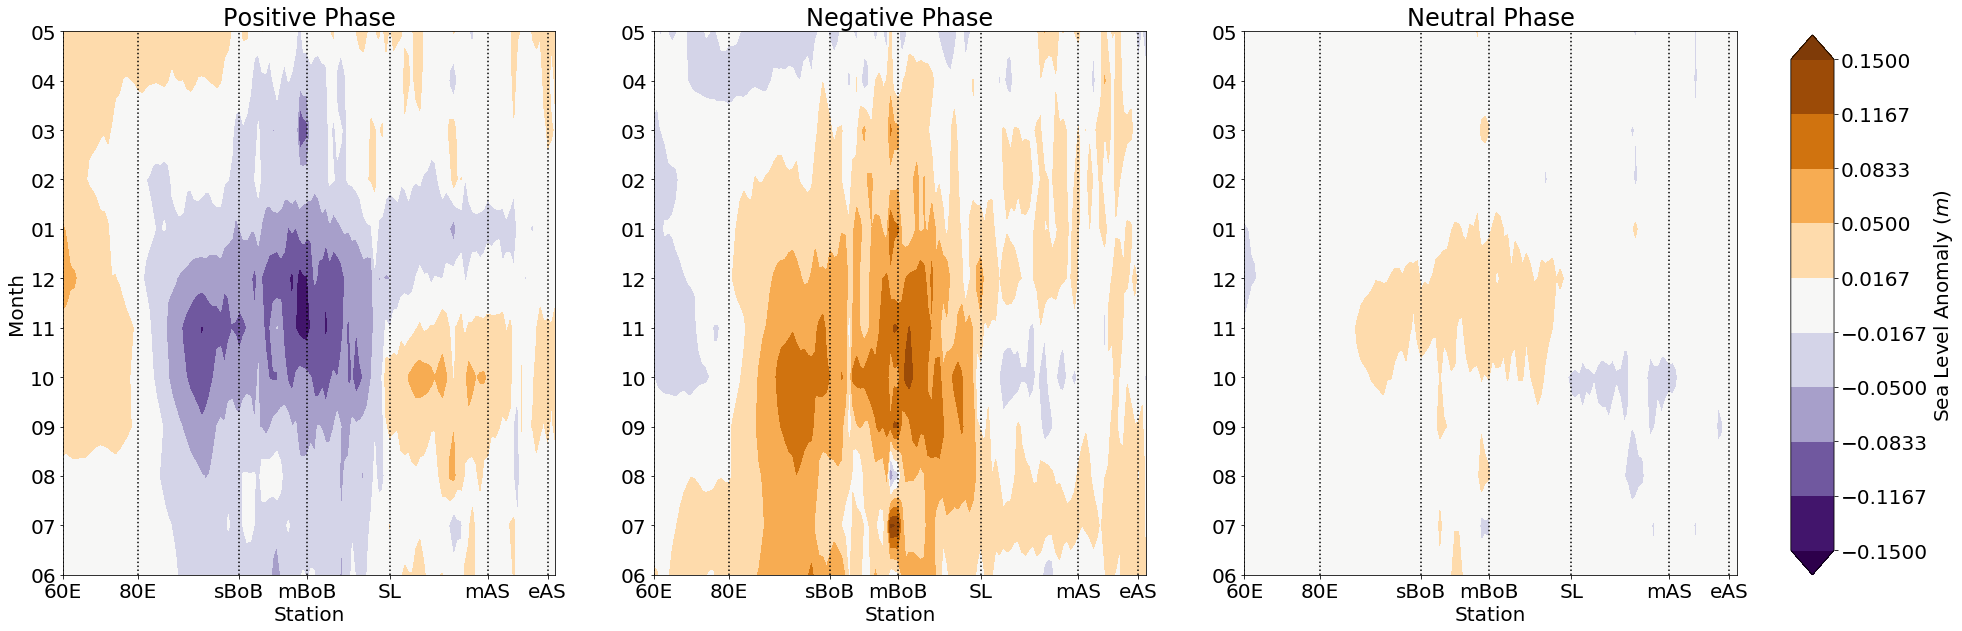

In [40]:
# create list of integer years
IODphases = list([posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])*np.nan
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

# plt.savefig('../figures/IOD-years-total-SLA-along-coast.png', dpi=300, bbox_inches='tight')




# Hovmueller Diagrams for 0.25 Degree

FileNotFoundError: [Errno 2] No such file or directory: '../figures/seasonal-and-IOD-years-SLA-along-coast-1-deg.png'

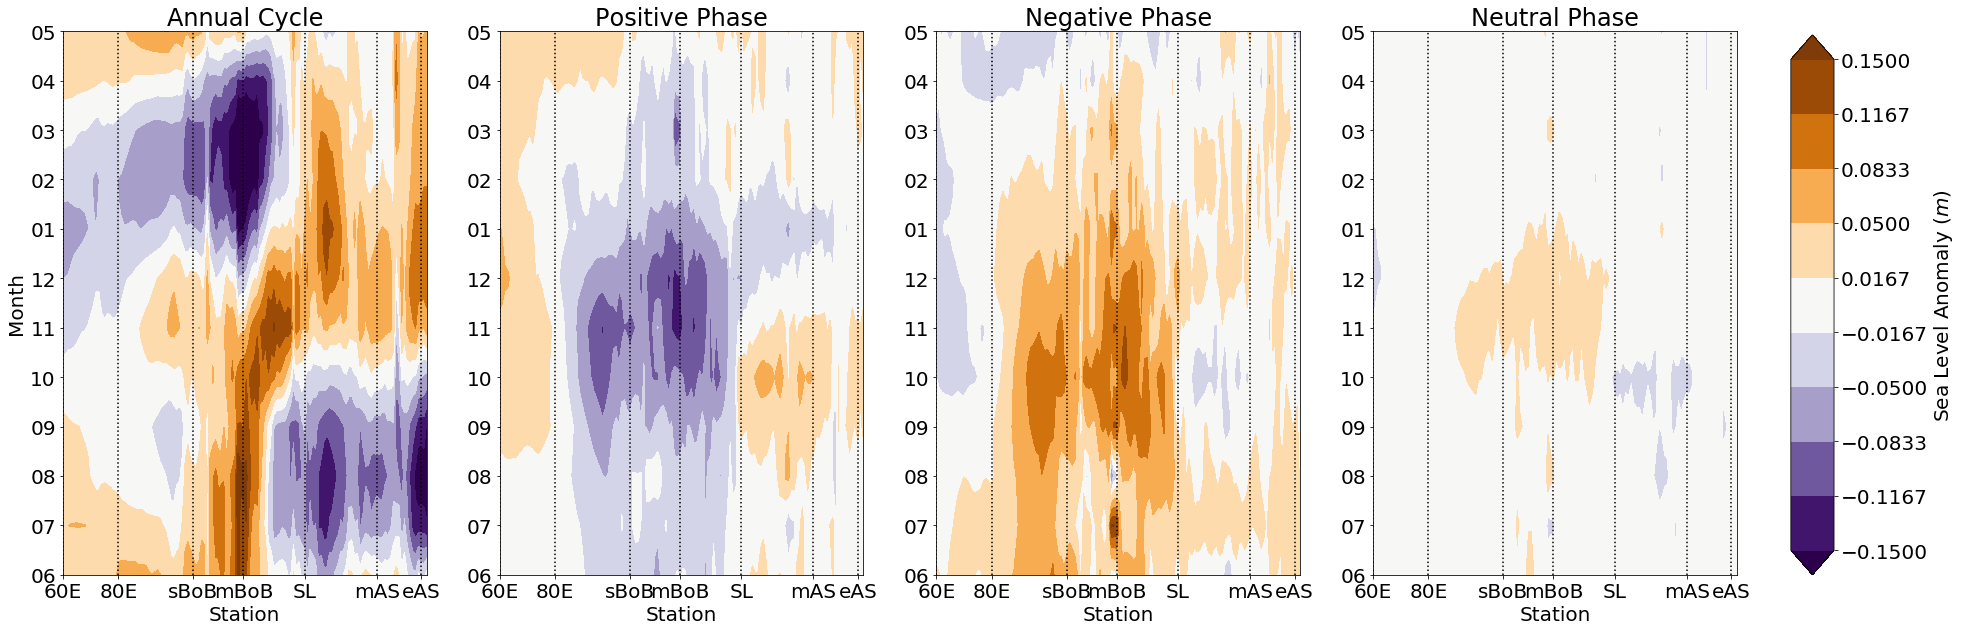

In [41]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-SLA-along-coast-1-deg.png', dpi=300, bbox_inches='tight')



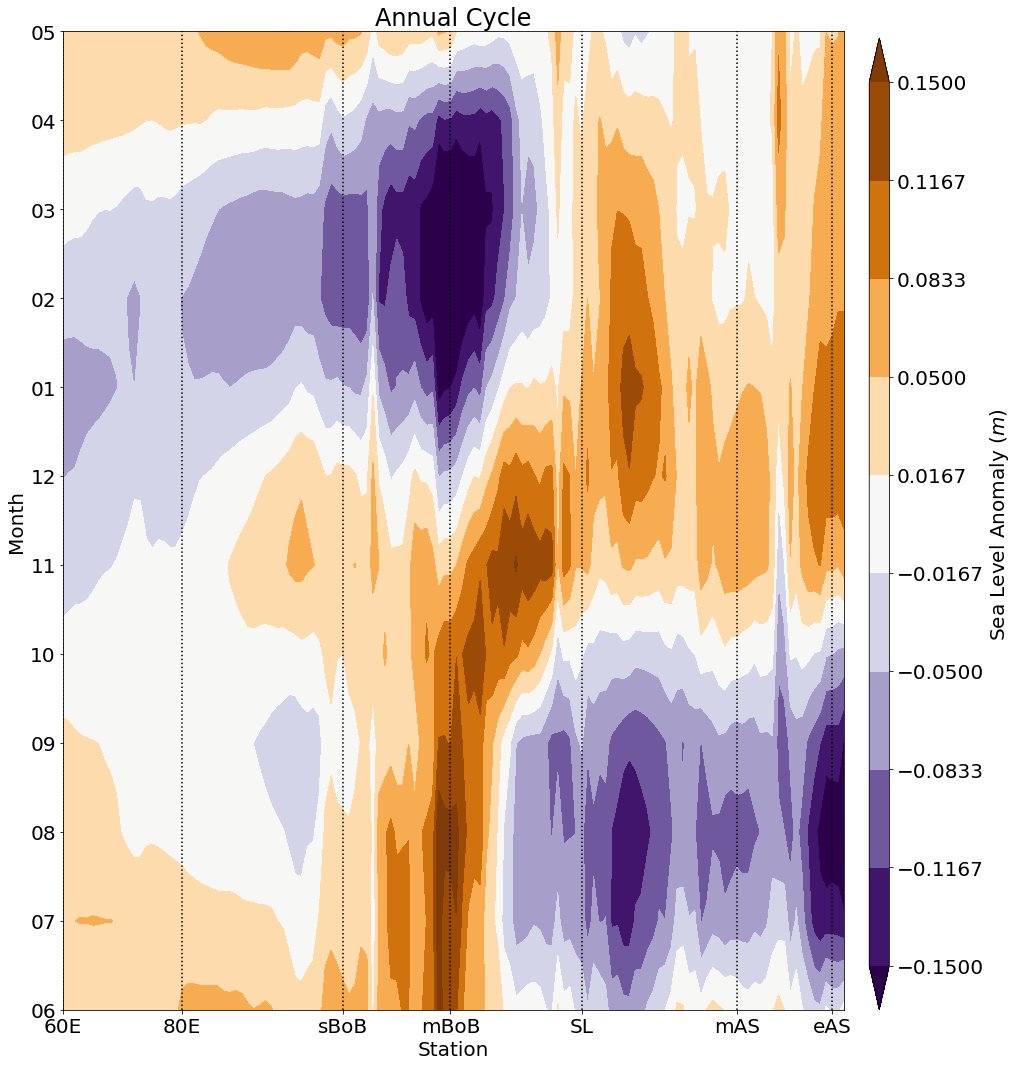

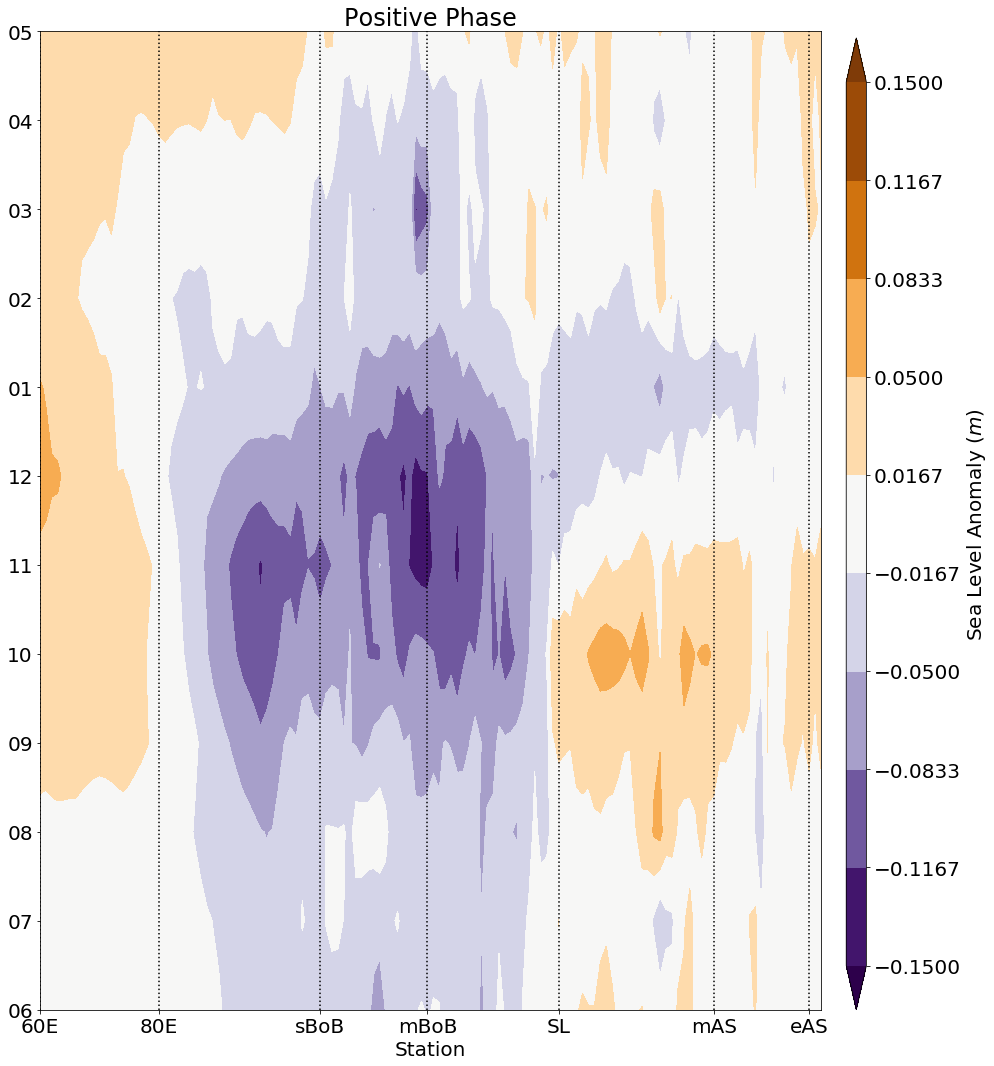

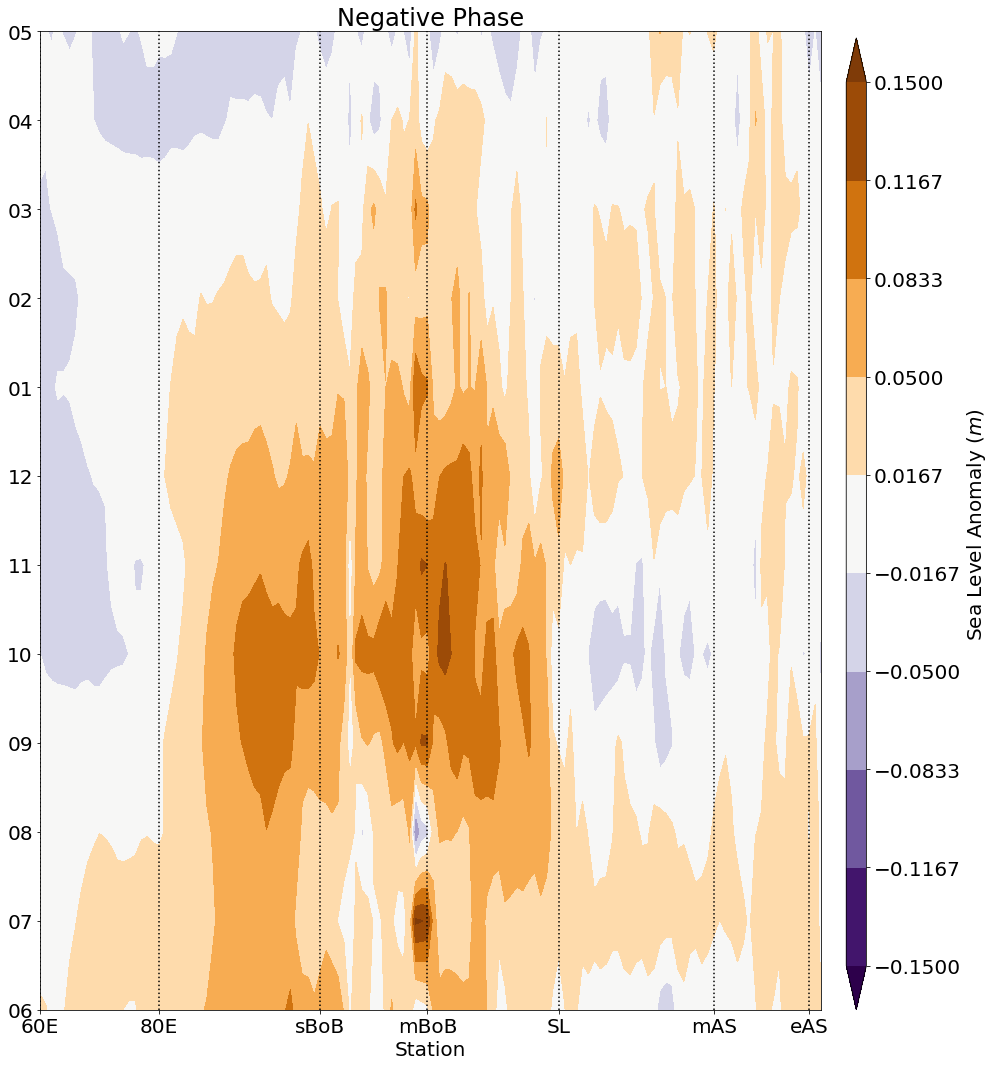

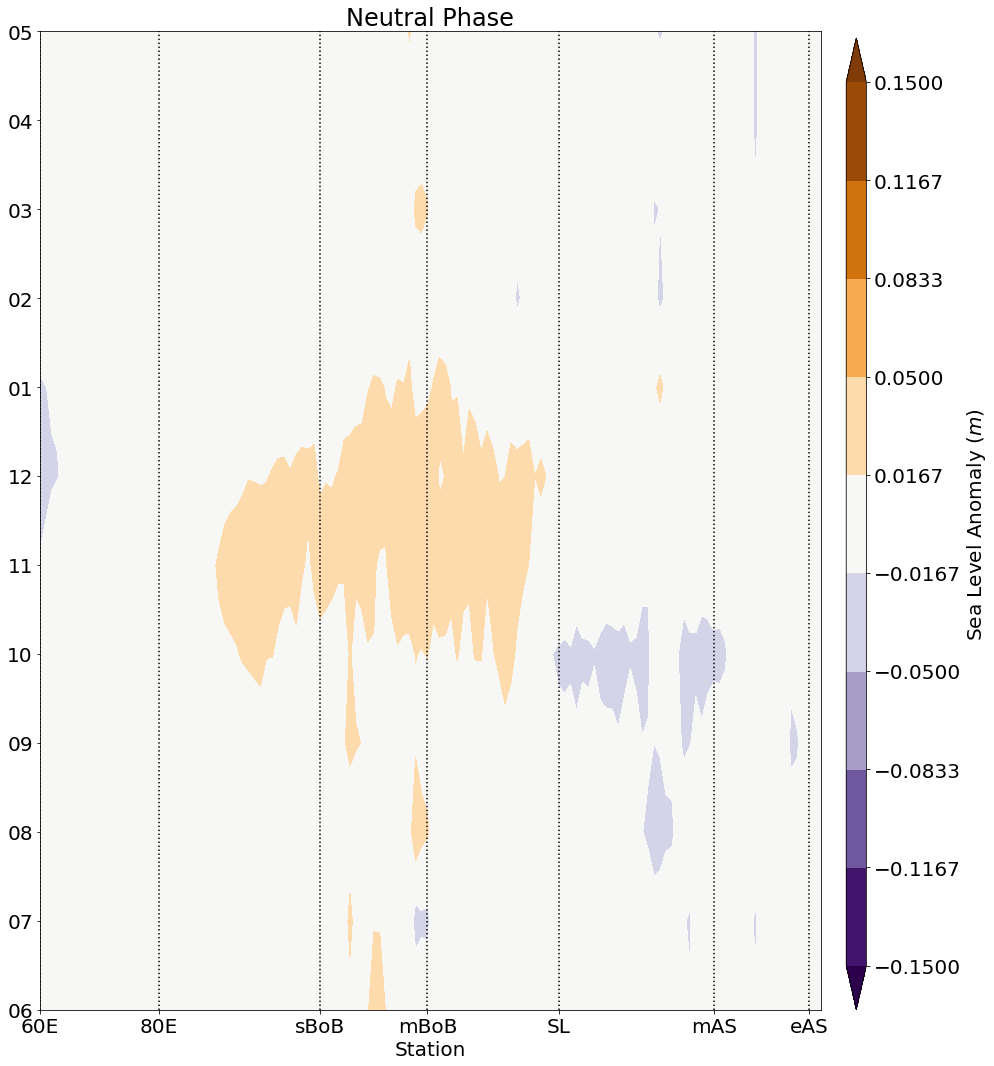

In [36]:
# singular plots 
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
titles_save = ['annual-cycle','positive-phase','negative-phase', 'neutral-phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

for ii,phase in enumerate(IODphases):
    
    fig = plt.figure(figsize=(14, 18))
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,1,1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label('Sea Level Anomaly ($m$)')
    plt.savefig('../figures/' + titles_save[ii] +'-SLA-along-coast-1-deg.png', dpi=300, bbox_inches='tight')




# Weak and Strong IOD Years

In [37]:
sposIODyears = [1994,1997,2006,2019]
wposIODyears = [2012, 2015, 2018]

# average over the strong positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(sposIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
sposIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
sposIOD_mon_sla_mon_anom_dtrnd = sposIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
sposIOD_mon_sla_mon_anom_dtrnd = sposIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the weak positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(wposIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
wposIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
wposIOD_mon_sla_mon_anom_dtrnd = wposIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
wposIOD_mon_sla_mon_anom_dtrnd = wposIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)


snegIODyears = [1996,2016]
wnegIODyears = [1998,2010]


# average over the strong negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(snegIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
snegIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
snegIOD_mon_sla_mon_anom_dtrnd = snegIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
snegIOD_mon_sla_mon_anom_dtrnd = snegIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the weak negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(wnegIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
wnegIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
wnegIOD_mon_sla_mon_anom_dtrnd = wnegIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
wnegIOD_mon_sla_mon_anom_dtrnd = wnegIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)




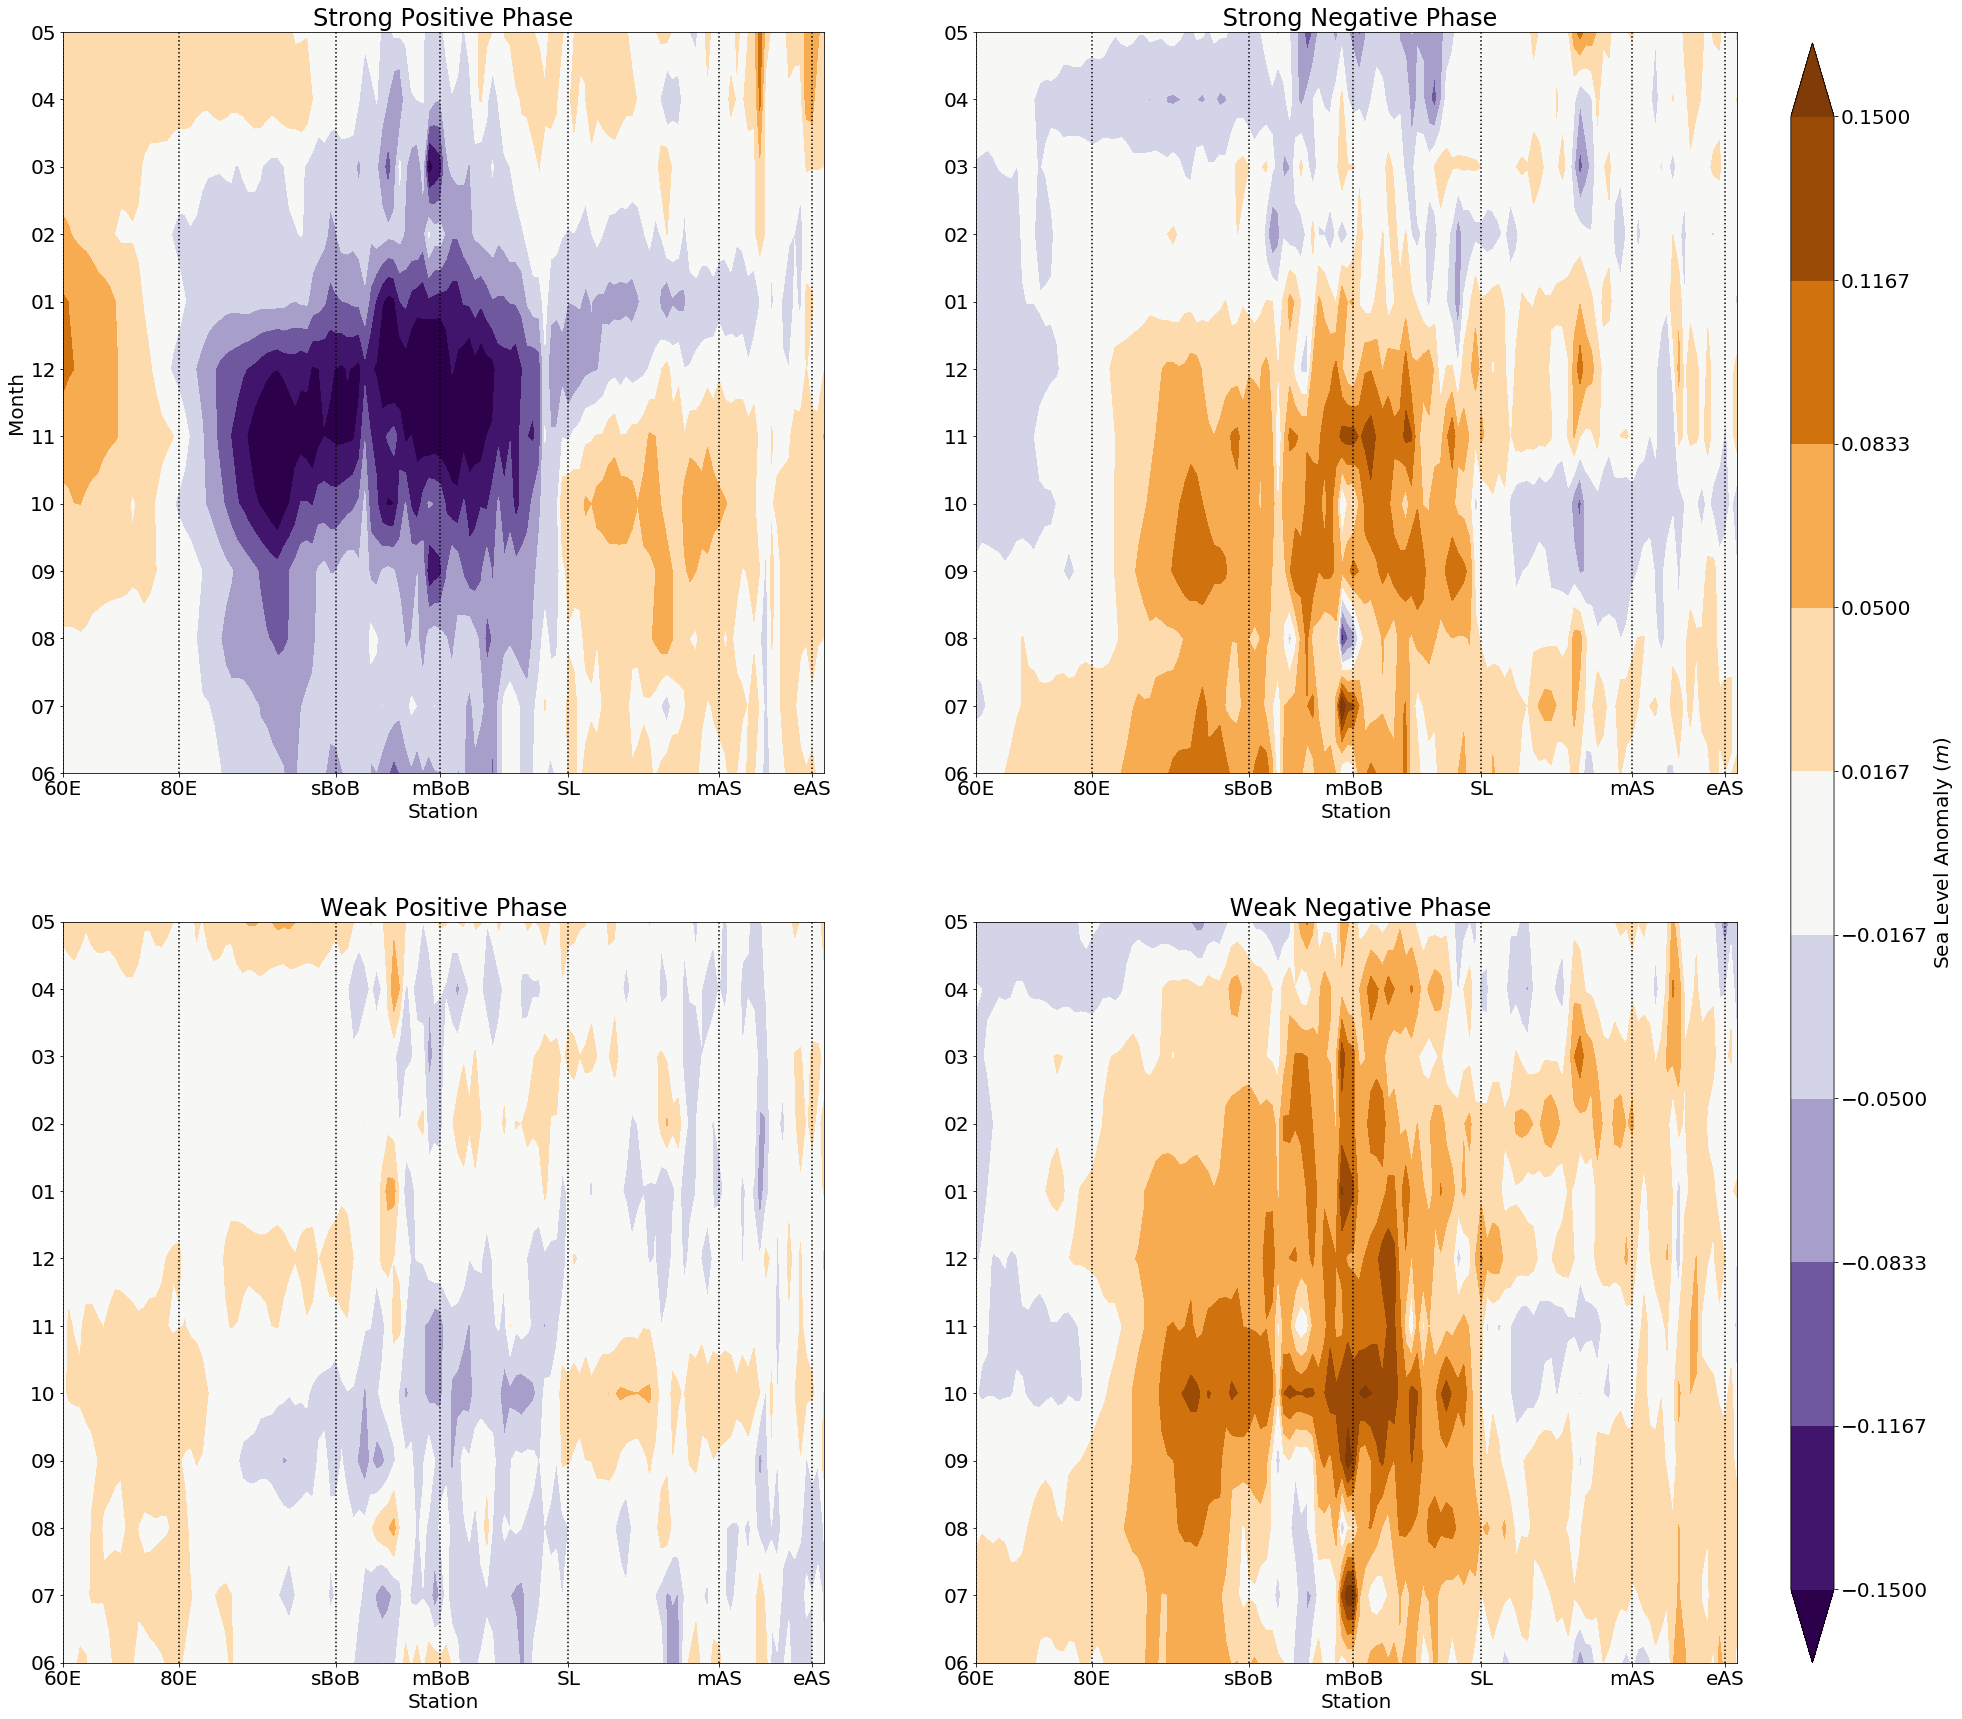

In [38]:
# create list of integer years
IODphases = list([sposIOD_mon_sla_mon_anom_dtrnd,snegIOD_mon_sla_mon_anom_dtrnd,
                 wposIOD_mon_sla_mon_anom_dtrnd,wnegIOD_mon_sla_mon_anom_dtrnd])
titles = ['Strong Positive Phase',' Strong Negative Phase','Weak Positive Phase',' Weak Negative Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(30, 30))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(2,2,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/strong-and-weak-IOD-years-SLA-along-coast-1-deg.png', dpi=300, bbox_inches='tight')



# Seasonal Cycle

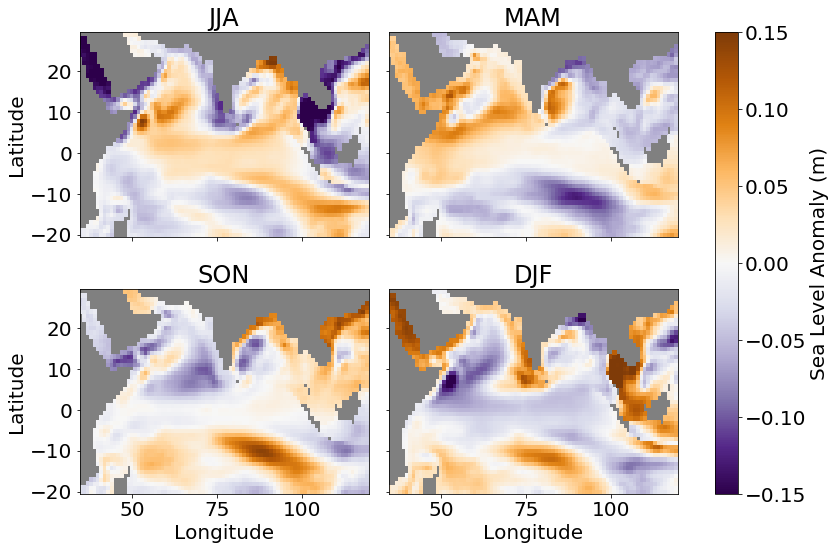

In [130]:
season = ['JJA','MAM','SON','DJF']

rolled_seas_cycle = ds_SLA.sla_seas_clim_dtrnd_1deg.roll(season=-1,roll_coords = False)
p = rolled_seas_cycle.plot.pcolormesh(x="longitude_1deg", y="latitude_1deg", col="season", col_wrap=2,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 8),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(season[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
plt.savefig('../figures/seasonal-cycle-SLA.png', dpi=300, bbox_inches='tight')

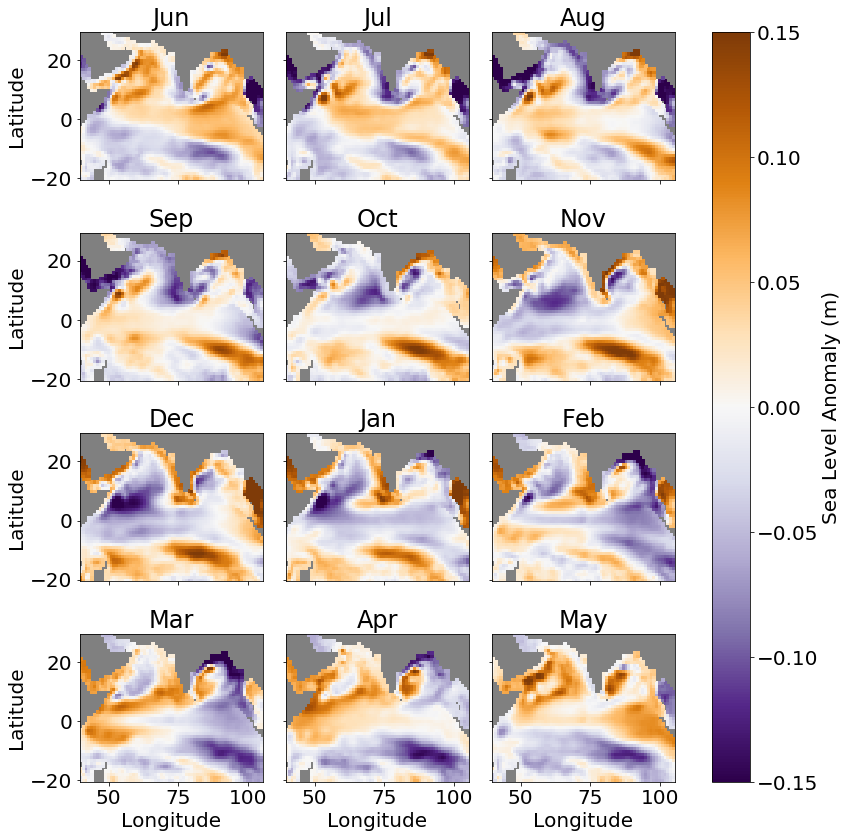

In [132]:
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

rolled_ann_cycle = ds_SLA.sla_mon_clim_dtrnd_1deg.roll(month=-5,roll_coords = False)
p = rolled_ann_cyc.plot.pcolormesh(x="longitude_1deg", y="latitude_1deg", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
plt.savefig('../figures/annual-cycle-SLA.png', dpi=300, bbox_inches='tight')

In [ ]:
# posIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

p = posIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# negIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May',]

p = negIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

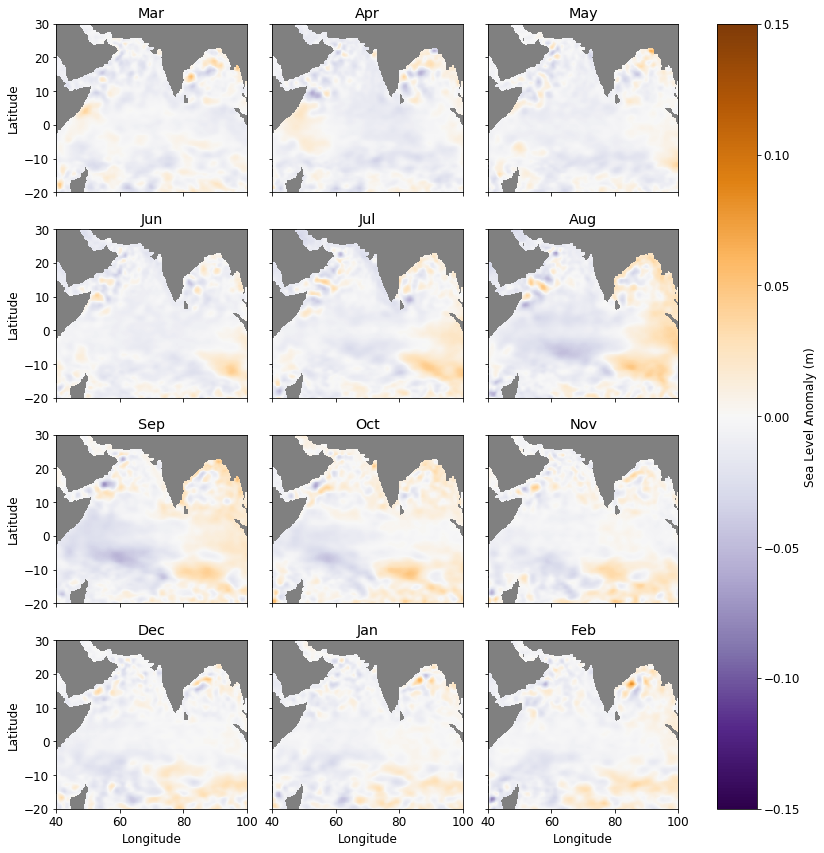

In [68]:
# neuIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = neuIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

# Differences between annual cycle and positive IOD years

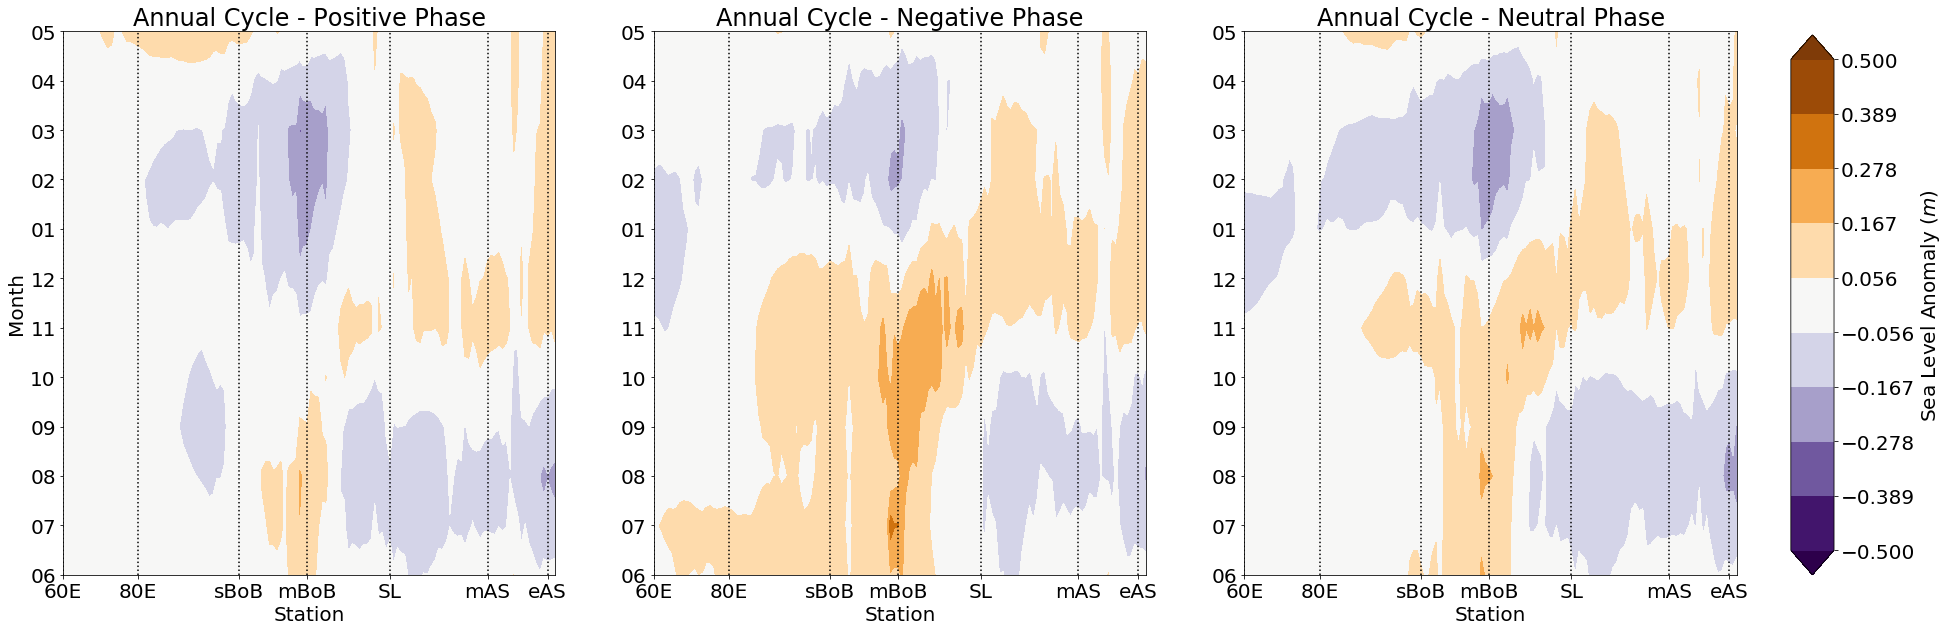

In [162]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.5
cmax = 0.5

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    seasdata = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]
        seasdata[:,jj] = rolled_ann_cyc[:,sta_latinds[jj],sta_loninds[jj]]

    var = (seasdata + data)
    
    
    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,var,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title('Annual Cycle - ' + titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-differences-SLA-along-coast.png', dpi=300, bbox_inches='tight')




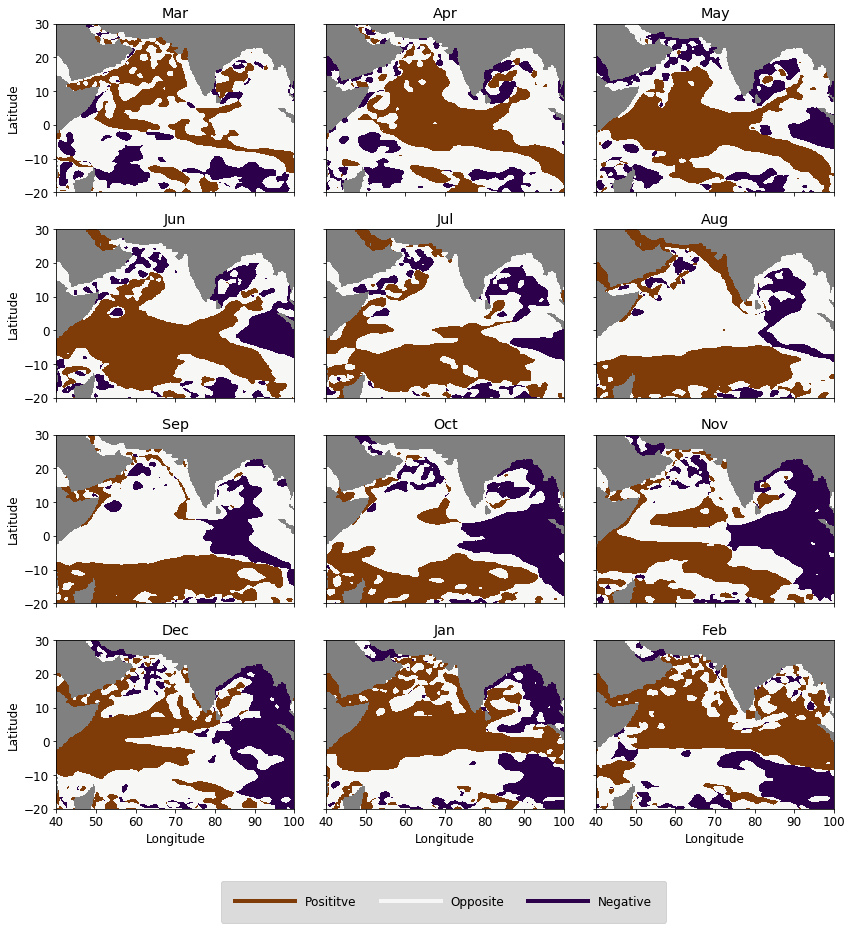

In [69]:
# posIOD

seas
iod = 
var = np.sign(posIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

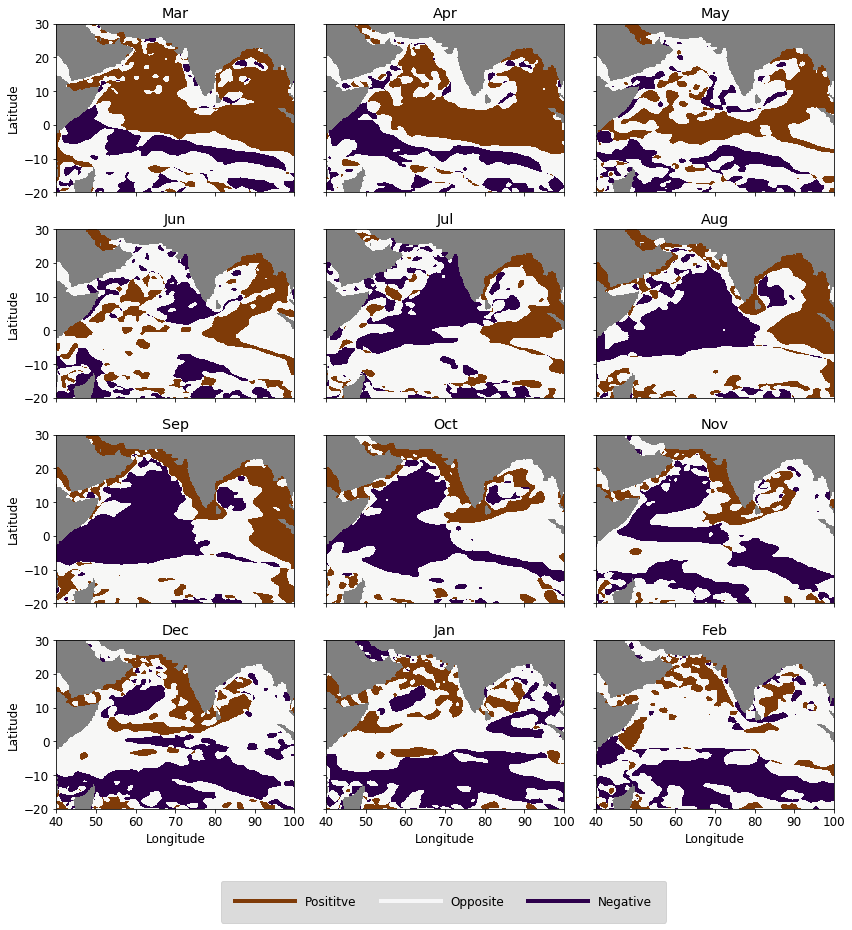

In [70]:
# negIOD

var = np.sign(negIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')